In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass
from typing import List

In [86]:
## CONSTANTS
VCO_F_MIN, VCO_F_MAX = 20, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000
ADC_MAX = 4095
WAVE_SIN, WAVE_TRI, WAVE_SQR, WAVE_SAW  = 0, 1, 2, 3 # waveshape "enum"

def additive_wave(waveshape, f, dur, Fs=48000, harmonic_derating=1):

    t = np.linspace(0, dur, int(dur*Fs), endpoint=False)
    x = 2*np.pi*t*f
    
    # add the fundamental
    wave = np.sin(x)

    if waveshape == WAVE_SIN:
        return wave

    max_harmonics = int(np.floor(Fs/2/f/harmonic_derating))

    # zero out the phase increments
    tri_offs = saw_offs = square_offs = 0

    # process harmonics higher than the first
    for k in range(2, max_harmonics+1):
        if waveshape == WAVE_TRI and k % 2 != 0: # only odd harmonics
            # tri
            tri_offs += np.pi
            new_wave_tri = (1/(k*k)) * np.sin(x*k + tri_offs)
            wave = [a + b for a, b in zip(wave, new_wave_tri)]
        elif waveshape == WAVE_SQR and k % 2 != 0: # only odd harmonics
            # square
            new_wave_square = (1/k) * np.sin(x*k)
            wave = [a + b for a, b in zip(wave, new_wave_square)]
        elif waveshape == WAVE_SAW:
            # saw
            saw_offs += np.pi
            new_wave_saw = (1/k) * np.sin(x*k + saw_offs)
            wave = [a + b for a, b in zip(wave, new_wave_saw)]

    return normalize(wave)

def plot_my_spectrogram(wave, dur, NFFT=128, Fs=48000, fmin=0, fmax=24000, dbmin=-80, dbmax=0):
    fig = plt.figure()
    ax = fig.add_subplot()
    _, _, _, im = ax.specgram(wave, Fs=Fs, NFFT=NFFT, noverlap=120, cmap='inferno');
    plt.axis([0, dur, fmin, fmax])
    ax.set_ylabel('frequency (Hz)')
    ax.set_xlabel('time (s)')
    cbar = plt.colorbar(im, ax=ax)
    plt.sci(im)
    plt.clim(dbmin, dbmax)
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    plt.show()

def plot_my_magnitude_spectrum(wave, Fs=48000, fmin=0, fmax=24000, dbmin=-80, dbmax=0):
    plt.figure(figsize=(20,5))
    plt.axis([fmin, fmax, dbmin, dbmax])
    plt.magnitude_spectrum(wave, scale='dB', Fs=Fs);
    
    
def plot_error(cycle1, cycle2, domain='frequency'):
    plt.figure()
    if domain == 'time':
        plt.plot([n1-n2 for n1, n2 in zip(cycle1, cycle2)])
    else:
        f1, _, _ = plt.magnitude_spectrum(cycle1)
        f2, _, _ = plt.magnitude_spectrum(cycle2)
        plt.figure()
        plt.plot([n1-n2 for n1, n2 in zip(f1, f2)])

# ModuleInput

In [116]:
class ModuleInput:
        
    def __init__(self, values, Fs=48000, range_from=0, range_to=1, inverted=False, noise_amount=0):
        self.Fs = Fs
        self.range_from = range_from
        self.range_to = range_to
        self.inverted = inverted
        noise = np.random.normal(0,noise_amount,len(values))
        self.values = [clamp(values[i]+noise[i], range_from, range_to) for i in range(len(values))]
        
    def to_voltages(self):
        voltages = [translate_range(v, self.range_from, self.range_to, 0, 3.3) for v in self.values]
        if self.inverted:
            voltages = [(3.3 - v) for v in voltages]
        return voltages

# ADC Simulator

In [117]:
class ADCSimulator:
    
    ''' Simulates the microcontroller ADC hardware. '''
    
    def __init__(self, adc_sample_rate):
        self.adc_sample_rate = adc_sample_rate

    def convert(self, inp):
        # convert the list 'values' based on the sampling rate of values specified in Fs
        idx_inc = inp.Fs / self.adc_sample_rate
        k = 0
        conversions = []
        voltages = inp.to_voltages()
        while k < len(voltages):
            # interpolate the voltage
            idx1 = int(k)
            idx2 = idx1 + 1
            if idx2 >= len(voltages):
                break
            val = crossfade(voltages[idx1], voltages[idx2], k-idx1)
            
            # convert the voltage to a 12-bit value
            conversion = int(translate_range(val, 0, 3.3, 0, ADC_MAX))
            conversions.append(conversion)
            k += idx_inc
        return conversions
    
class ADC_Processor:
        
    def __init__(self):
        ...
        
    def filter(self):
        ...

@dataclass
class Parameter:
    conversions: List[float]
    adc_sample_rate: int
    Fs: int = 48000
    k: float = 0
        
    def next(self):
        idx1 = int(self.k)
        idx2 = idx1 + 1
        num_conversions = len(self.conversions)
        if idx2 >= num_conversions:
            return self.conversions[idx1]
        val = crossfade(self.conversions[idx1], self.conversions[idx2], self.k-idx1)
        self.k += self.adc_sample_rate / self.Fs
        return val

# Oscillator

In [118]:
'''
Note: This code is derived from Emilie Gillet's code for Mutable Instruments' Plaits. Copyright included below.

// Copyright 2016 Emilie Gillet.
//
// Author: Emilie Gillet (emilie.o.gillet@gmail.com)
//
// Permission is hereby granted, free of charge, to any person obtaining a copy
// of this software and associated documentation files (the "Software"), to deal
// in the Software without restriction, including without limitation the rights
// to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
// copies of the Software, and to permit persons to whom the Software is
// furnished to do so, subject to the following conditions:
// 
// The above copyright notice and this permission notice shall be included in
// all copies or substantial portions of the Software.
// 
// THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
// IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
// FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
// AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
// LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
// OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
// THE SOFTWARE.
// 
// See http://creativecommons.org/licenses/MIT/ for more information.
//
// -----------------------------------------------------------------------------
'''

class Oscillator:
    
    def __init__(self, shape, frequency_cv, pw_cv, polyblep=True):
        self.shape = shape
        self.frequency_cv = frequency_cv
        self.pw_cv = pw_cv
        self.phase = 0.5
        self.output = []
        self.next_sample = 0
        self.high = True
        self.cycles = []
        self.cycle = []
        self.polyblep = polyblep
        
    def get_output(self):
        return self.output
    
    # based on:
    def polyblep_this(self, t):
        return 0.5 * t * t

    def polyblep_next(self, t):
        t = 1 - t
        return -0.5 * t * t

    def polyblep_integrated_next(self, t):
        t1 = 0.5 * t
        t2 = t1 * t1
        t4 = t2 * t2
        return 0.1875 - t1 + 1.5 * t2 - t4

    def polyblep_integrated_this(self, t):
        return polyblep_integrated_next(1 - t)
        
    def render(self, buff_size):
        i = 0
        while i < buff_size:
            this_sample = self.next_sample
            self.next_sample = 0
            
            frequency = self.frequency_cv.next()
            pw = self.pw_cv.next()
    
            self.phase += frequency

            # save the cycle output
            if self.phase >= 1:
                self.cycles.append(self.cycle)
                self.cycle = []

            if self.shape == WAVE_SIN:
                y = np.sin(2*np.pi*self.phase)
            elif self.shape == WAVE_SAW: 
                if self.phase >= 1:
                    self.phase -= 1
                    if self.polyblep:
                        t = self.phase / frequency
                        this_sample -= self.polyblep_this(t)
                        self.next_sample -= self.polyblep_next(t)
                y = (2 * this_sample) - 1
                self.next_sample += self.phase
            elif self.shape == WAVE_SQR:
                if (self.high and self.phase < pw) or (not self.high and self.phase >= pw):
                    # if in here then we are at an edge
                    if self.polyblep:
                        t = (self.phase - pw) / frequency
                        this_sample += self.polyblep_this(t)
                        self.next_sample += self.polyblep_next(t)
                    self.high = not self.high
                if self.phase >= 1:
                    self.phase -= 1
                    if self.polyblep:
                        t = self.phase / frequency
                        this_sample -= self.polyblep_this(t)
                        self.next_sample -= self.polyblep_next(t)
                    self.high = False
                self.next_sample += 0 if self.phase < pw else 1
                this_sample = (2 * this_sample) - 1
                y = this_sample
            elif self.shape == WAVE_TRI:
                pw = 0.5
                slope_up = slope_down = 2
                # high = True during rising ramp, False during falling ramp
                if (self.high and self.phase >= pw) or (not self.high and self.phase < pw):
                    # if in here, the ramp is changing direction
                    if self.polyblep:
                        t = (phase - pw) / phase_inc
                        discontinuity = (slope_up + slope_down) * phase_inc
                        this_sample -= self.polyblep_integrated_this(t) * discontinuity
                        self.next_sample -= self.polyblep_integrated_next(t) * discontinuity
                    self.high = not self.high
                if self.phase >= 1: # cycle reset
                    self.phase -= 1
                    if self.polyblep:
                        t = self.phase / frequency
                        discontinuity = (slope_up + slope_down) * frequency
                        this_sample += self.polyblep_integrated_this(t) * discontinuity
                        self.next_sample += self.polyblep_integrated_next(t) * discontinuity
                    self.high = True
                self.next_sample += (self.phase * slope_up) if self.high else 1 - (self.phase - pw) * slope_down
                y = (2 * this_sample) - 1 

            self.output.append(y)
            self.cycle.append(y)
            i += 1

# playback

In [119]:
### Sample calculation code inspired by Mutable Instruments Plaits

class Playback:
    
    def __init__(self, Fs=48000):
        self.Fs = Fs

    def play(self, inputs, num_samples, polyblep=True, show_progress=False, listen=True, plot=True, buff_size=64):
        # retrieve test inputs
        shape = inputs['waveshape']
        mode = inputs['mode']
        coarse_pot = inputs['coarse']
        fine_pot = inputs['fine']
        vpo_cv = inputs['vpo']
        fm_cv = inputs['fm']
        pwm_cv = inputs['pwm']
        
        # convert the test inputs with a simulated ADC
        adc_sim = ADCSimulator(1000)
        coarse_conv = adc_sim.convert(coarse_pot)
        fine_conv = adc_sim.convert(fine_pot)
        vpo_conv = adc_sim.convert(vpo_cv)
        fm_conv = adc_sim.convert(fm_cv)
        pwm_conv = adc_sim.convert(pwm_cv)
                
        ## FILTER inputs
        # todo    
        coarse = coarse_conv
        fine = fine_conv
        vpo = vpo_conv
        fm = fm_conv
        pwm = pwm_conv
            
        ## PARAMETERIZE ADC CONVERSIONS

        # calculate the frequency parameter
        frequency_list = [] # stores phase increments
        num_adc_conversions = len(coarse_conv)
        for i in range(num_adc_conversions):
            if mode == 0:
                # normalize ADC inputs
                coarse_translated = translate_range(coarse[i], 0, ADC_MAX, 0, 10)
                fine_translated = translate_range(fine[i], 0, ADC_MAX, 0, 1)
                volt_from_vpo = translate_range(vpo[i], 0, ADC_MAX, -5, 5)
                volt_from_fm = translate_range(fm[i], 0, ADC_MAX, -5, 5)
                
                # calculate frequency
                f = VCO_F_MIN * 2**(coarse_translated + fine_translated)
                f *= 2**volt_from_vpo
                f *= 2**volt_from_fm
                f = clamp(f, VCO_F_MIN, VCO_F_MAX) # clamp the frequency to within allowable range
            elif mode == 1:
                f = translate_range(coarse[i], 0, ADC_MAX, LFO_F_MIN, LFO_F_MAX)

            frequency = f / self.Fs # phase increment
            frequency_list.append(frequency)
        
        frequency_param = Parameter(frequency_list, adc_sim.adc_sample_rate, self.Fs)
        pwm_param = Parameter(pwm, adc_sim.adc_sample_rate, self.Fs)
        
        oscillator = Oscillator(shape, frequency_param, pwm_param, polyblep)
                
        # create N samples
        i = 0
        while i < num_samples:
            buff_size = min(buff_size, num_samples - i)
            oscillator.render(buff_size)
            
            i += buff_size
                
            # progress indication
            if show_progress:
                prog = 100*i/cvsim.N
                if prog % 10 == 0:
                    print(prog, "%")   
                        
        wave = np.array(oscillator.get_output())
        
        # create output audio and plot
        if listen:
            display(ipd.Audio(wave, rate=self.Fs))
        if plot:
            dur = len(wave) / self.Fs
            plot_my_spectrogram(wave, dur, Fs=self.Fs)

        return wave, []

# examples

In [120]:
# create the playback task
pb = Playback()

def f_to_dec(f, mode=0):
    if mode == 1:  # lfo
        f = clamp(f, LFO_F_MIN, LFO_F_MAX)
        return translate_range(f, LFO_F_MIN, LFO_F_MAX, 0, 1)
    
    # vco
    f = clamp(f, VCO_F_MIN, VCO_F_MAX)
    return .1*np.log2(f/20)

class SignalGenerator:
    
    def __init__(self, dur, Fs):
        self.dur = dur
        self.Fs = Fs
        self.N = dur * Fs
        
    def const_inp(self, val):            
        return [val] * self.N

    def ramp_inp(self, from_val, to_val):
        return np.linspace(from_val, to_val, self.N)

    def sin_inp(self, A, f):
        t = np.linspace(0, self.dur, self.N)
        return A*np.sin(2*np.pi*t*f)
    
    # todo: noise, mix

def reset_inputs(signal_generator):
    num_samples = signal_generator.N
    zeros = signal_generator.const_inp(0)
    f220 = signal_generator.const_inp(f_to_dec(220))
    
    inputs = dict()
    inputs['waveshape'] = WAVE_SAW
    inputs['mode'] = 0
    inputs['coarse'] = ModuleInput(values=f220)
    inputs['fine'] = ModuleInput(values=zeros)
    inputs['vpo'] = ModuleInput(values=zeros, range_from=-5, range_to=5)
    inputs['fm'] = ModuleInput(values=zeros, range_from=-5, range_to=5)
    inputs['pwm'] = ModuleInput(values=zeros, range_from=-5, range_to=5)
    return inputs, num_samples

## constant frequency (additive vs. naive vs. anti-aliased)

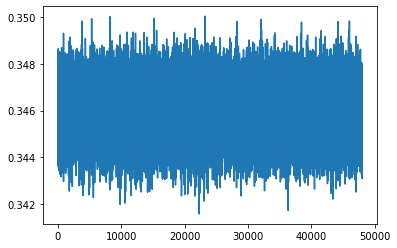

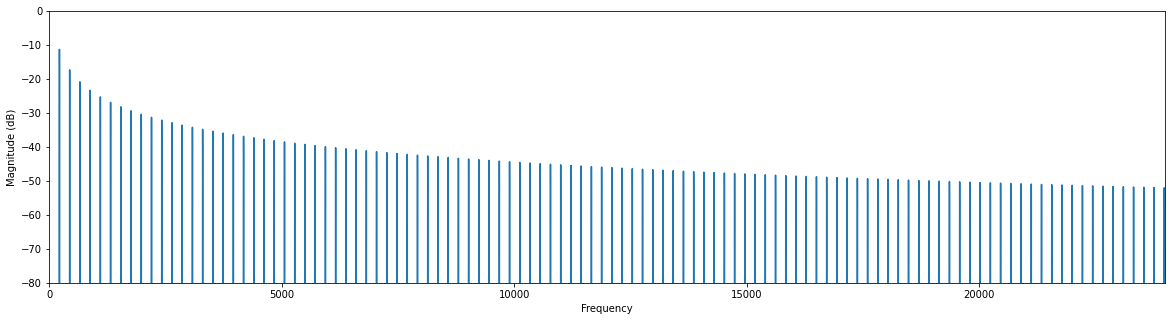

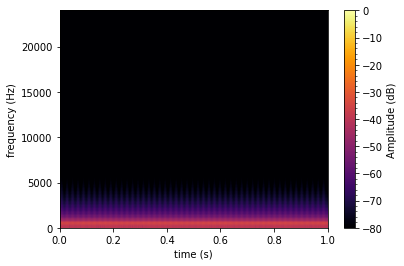

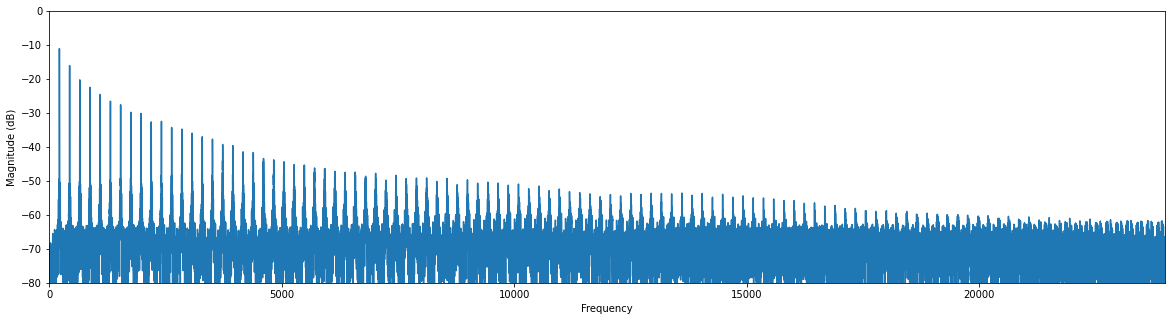

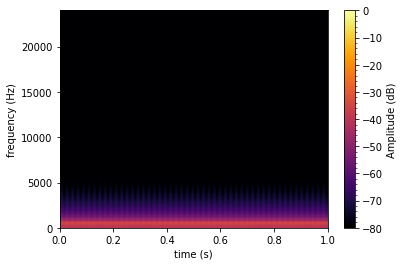

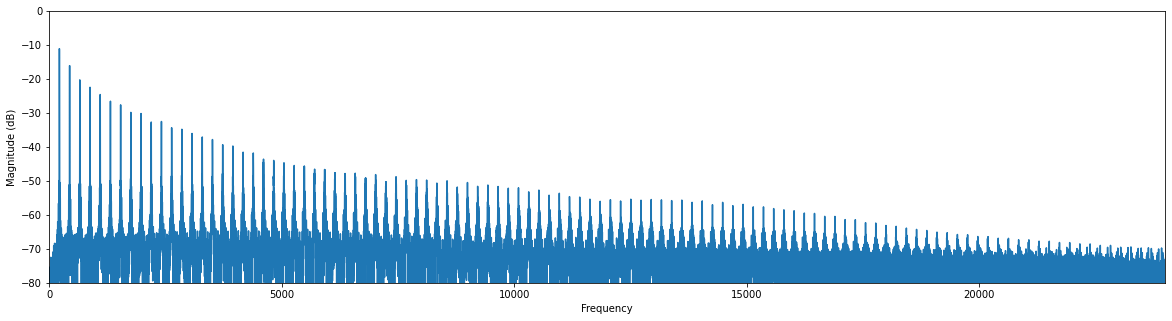

In [130]:
ig1 = SignalGenerator(dur=1, Fs=48000)
inputs, num_samples = reset_inputs(ig1)

inputs['coarse'] = ModuleInput(values=ig1.const_inp(f_to_dec(220)), noise_amount=0.001)

# additive wave
wave = additive_wave(WAVE_SAW, 220, 1)
plot_my_magnitude_spectrum(wave)
display(ipd.Audio(wave, rate=48000))

# naive
wave2, cycles2 = pb.play(inputs, num_samples, plot=False, listen=True, polyblep=False); # no polyblep
plot_my_magnitude_spectrum(wave2)

# with polyblep
wave1, cycles1 = pb.play(inputs, num_samples, plot=False, listen=True, polyblep=True); # polyblep
plot_my_magnitude_spectrum(wave1)

## frequency sweep

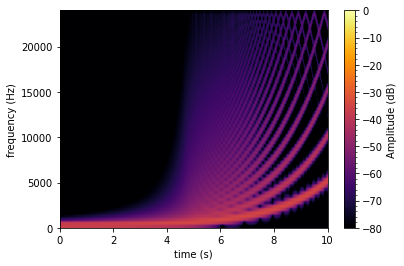

In [133]:
ig = SignalGenerator(dur=10, Fs=48000)
inputs, num_samples = reset_inputs(ig)

inputs['coarse'] = ModuleInput(values=ig.ramp_inp(0.1, 0.8), noise_amount=0.001)

wave1, _ = pb.play(inputs, num_samples, plot=True, listen=True, polyblep=True); # polyblep

## fine adjust

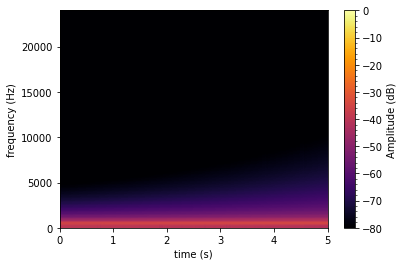

In [25]:
ig = SignalGenerator(dur=5, Fs=48000)
inputs, num_samples = reset_inputs(ig)

inputs['fine'] = ModuleInput(values=ig.ramp_inp(0, 0.5))

wave1, _ = pb.play(inputs, num_samples, plot=True, listen=True, polyblep=True); # polyblep

## ramp one volt/octave at constant coarse

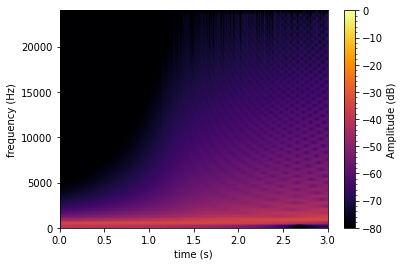

In [26]:
ig = SignalGenerator(dur=3, Fs=48000)
inputs, num_samples = reset_inputs(ig)

inputs['vpo'] = ModuleInput(values=ig.ramp_inp(0, 2), range_from= -5, range_to=5)

wave1, _ = pb.play(inputs, num_samples, plot=True, listen=True, polyblep=True); # polyblep

## expo FM at constant coarse

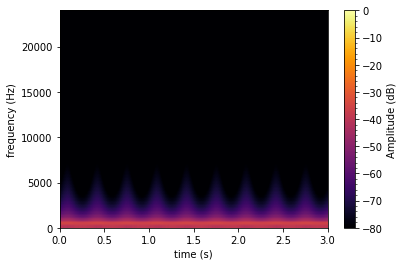

In [29]:
ig = SignalGenerator(dur=3, Fs=48000)
inputs, num_samples = reset_inputs(ig)

inputs['fm'] = ModuleInput(values=ig.sin_inp(A=0.3, f=3), range_from= -5, range_to=5)

wave1, _ = pb.play(inputs, num_samples, plot=True, listen=True, polyblep=True); # polyblep

## expo FM on ramping pitch

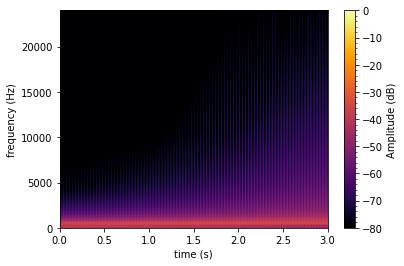

In [32]:
ig = SignalGenerator(dur=3, Fs=48000)
inputs, num_samples = reset_inputs(ig)

inputs['coarse'] = ModuleInput(values=ig.ramp_inp(f_to_dec(220), f_to_dec(440)))
inputs['fm'] = ModuleInput(values=ig.sin_inp(A=0.3, f=30), range_from= -5, range_to=5)

wave1, _ = pb.play(inputs, num_samples, plot=True, listen=True, polyblep=True); # polyblep

## LFO

In [ ]:
cvsim = CV_sim(dur=1)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SQR))
cvsim.set('mode', cvsim.const_inp(1))
cvsim.set('coarse_adj', cvsim.const_inp(f_to_dec(2, mode=1)))
out, cycles = pb.play(cvsim);
plt.plot(out)

## PWM

In [ ]:
cvsim = CV_sim(dur=5)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SQR))
cvsim.set('coarse_adj', cvsim.const_inp(f_to_dec(220)))
# cvsim.set('pwm', cvsim.sin_inp(A=5, f=0.1))
cvsim.set('pwm', cvsim.ramp_inp(-5,5))


i = 7 * (len(cycles2) - 1) // 8
wave1, cycles1 = pb.play(cvsim, polyblep=True); # polyblep
plt.figure()
plt.plot(cycles1[i])